## Salt Lithology Model

Run every cell (`Shift+Enter`)

### Imports

In [110]:
import pandas as pd
import math
from typing import List, Any
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict


### Sample Data

#### Known Data

In [ ]:
# get this data!!

# initially estimate disutribution as uniform within range
class SaltOccurrences:
    def __init__(self, salt: str, ranges: dict):
        self.min = ranges.get(salt).get("min", -math.inf)
        self.max = ranges.get(salt).get("max", math.inf)

    def generate_distributed_data(self, num_points: int = 10000) -> List[float]:
        if self.min == -math.inf or self.max == math.inf:
            raise ValueError("Cannot generate data for unbounded ranges.")
        
        return np.random.uniform(self.min, self.max, num_points).tolist()


#### Field Measurement

In [4]:
data_file = r"C:\Users\HarrisEdlmann\PycharmProjects\salt-lithology-model\data\Salt_Lithology_Mapping_Model.xlsx"

RUDSTON_2_DATA = pd.read_excel(
    data_file,
    sheet_name="Rudston 2 data",
    header=0,            # first row are column headers (default)
    dtype=float,         # try to cast all columns to float
    engine="openpyxl",   # explicit engine for .xlsx
    na_values=["", "NA"] # optional: treat these as NaN
)

# add more data here ...

### Ranges

for each meaurement,

1. define ranges for each salt
2. plot ranges

    for each salt,

    1. model a distribution within the range
    2. convert distribution into weighting

#### src

In [5]:
class RangePlotter:
    def __init__(self, measurement: str, ranges: dict):
        self.ranges = ranges
        self.measurement = measurement

    def plot_ranges(self):
        # Prepare data
        salts = []
        mins = []
        maxs = []
        
        for salt, range_ in self.ranges.items():
            if range_["min"] is not None and range_["max"] is not None:
                salts.append(salt)
                mins.append(range_["min"])
                maxs.append(range_["max"])
        
        # Smaller figure: reduce figsize and/or DPI
        fig, ax = plt.subplots(figsize=(6, 4), dpi=100)

        # Plot horizontal lines for each salt's range with thicker lines and no markers
        for i, (min_val, max_val) in enumerate(zip(mins, maxs)):
            ax.hlines(y=i, xmin=min_val, xmax=max_val, linewidth=3, color='#0b1854')
        
        # Tidy appearance with smaller fonts
        ax.set_yticks(list(range(len(salts))))
        ax.set_yticklabels(salts, fontsize=8)
        ax.set_xlabel(f"{self.measurement} Value", fontsize=9)
        ax.set_title(f"{self.measurement} Ranges for Different Salts", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.5)
        
        plt.tight_layout()
        # Optional: save smaller image to file
        # plt.savefig('gr_ranges_small.png', dpi=150, bbox_inches='tight', pad_inches=0.1)
        plt.show()
        


In [79]:
class WeightingFunction:    
    def __init__(self, bin_edges: List[float], counts: List[int]):
        self.bin_edges = np.array(bin_edges)
        self.counts = np.array(counts)
        self.total_counts = np.sum(self.counts)

    def calculate_weighting(self, measurement: float) -> float:
        # Handle edge case of no counts
        if self.total_counts == 0:
            return 0.0
            
        # Find which bin the measurement falls into
        for i in range(len(self.bin_edges) - 1):
            left, right = self.bin_edges[i], self.bin_edges[i + 1]
            
            # Handle last bin edge inclusive
            if i == len(self.bin_edges) - 2:
                if left <= measurement <= right:
                    return float(self.counts[i]) / float(self.total_counts)
            else:
                if left <= measurement < right:
                    return float(self.counts[i]) / float(self.total_counts)
                    
        # Measurement outside all bins
        return 0.0
    

class RangeModeler:    
    def __init__(self, salt: str, measurement:str, ranges: dict, data: SaltOccurrences, bins: int = 10):
        self.salt = salt
        self.measurement = measurement
        self.ranges = ranges
        self.data = data
        self.bins = bins
        self.error = False
        self.process_data()

    def process_data(self):
        if self.salt not in self.ranges:
            self.error = True
            return
            # raise KeyError(f"{self.salt} not in {self.meaurement}_RANGES")

        srange = self.ranges[self.salt]
        smin, smax = srange.get("min"), srange.get("max")
        if smin is None or smax is None:
            self.error = True
            return
            # raise ValueError(f"No numeric {self.measurement} range for {self.salt}")
    
        # build bin edges
        if isinstance(self.bins, int):
            bin_edges = np.linspace(smin, smax, self.bins + 1)
        else:
            bin_edges = np.asarray(self.bins, dtype=float)
            if bin_edges.ndim != 1 or bin_edges.size < 2:
                self.error = True
                return
                # raise ValueError("bins must be an int or a 1D array-like of edges")

        # count occurrences per bin
        obs = self.data.generate_distributed_data()

        counts = []
        for i in range(len(bin_edges) - 1):
            left, right = bin_edges[i], bin_edges[i + 1]
            if i == len(bin_edges) - 2:
                mask = (obs >= left) & (obs <= right)  # include right edge for last bin
            else:
                mask = (obs >= left) & (obs < right)
            counts.append(int(mask.sum()))

        counts = np.array(counts)

        self.bin_edges = bin_edges
        self.counts = counts

        self.weighting_function = WeightingFunction(self.bin_edges, self.counts)

    def plot_salt_histogram(self):
        if self.error:
            # print(f"Cannot plot histogram for {self.salt} due to missing range data.")
            return

        centers = (self.bin_edges[:-1] + self.bin_edges[1:]) / 2
        widths = self.bin_edges[1:] - self.bin_edges[:-1]

        # plot
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.bar(centers, self.counts, width=widths, align='center', color='tab:blue', edgecolor='k', linewidth=0.5)

        ax.set_xlabel(f"{self.measurement} value (bin)")
        ax.set_ylabel(f"Count")
        ax.set_title(f"Occurrences of '{self.salt}' in {self.measurement} range")
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

    def calculate_weighting(self, measurement):
        if self.error:
            # print(f"Cannot calculate weighting for {self.salt} due to missing range data.")
            return 0.0
        return self.weighting_function.calculate_weighting(measurement)


#### GR

In [80]:
GR_RANGES = {
    "Halite": {"min": 0, "max": 30},
    "Sylvite": {"min": 500, "max": 747},
    "Bischofite": {"min": 0, "max": 0},
    "Carnallite": {"min": 100, "max": 220},
    "Tachydrite": {"min": 0, "max": 10},
    "Kainite": {"min": 245, "max": 285.42},
    "Anhydrite": {"min": 0, "max": 70},
    "Gypsum": {"min": 0, "max": 0},
    "Kieserite": {"min": 0, "max": 0},
    "Langbeinite": {"min": 268, "max": 290},
    "Polyhalite": {"min": 180, "max": 200},
    "Barite": {"min": 0, "max": 0},
    "Calcite": {"min": 10, "max": 100},
    "Dolomite": {"min": 10, "max": 20},
    "Silt / Sandstone": {"min": 0, "max": 60},
    "Clay / Mudstone": {"min": 10, "max": 1000},
}


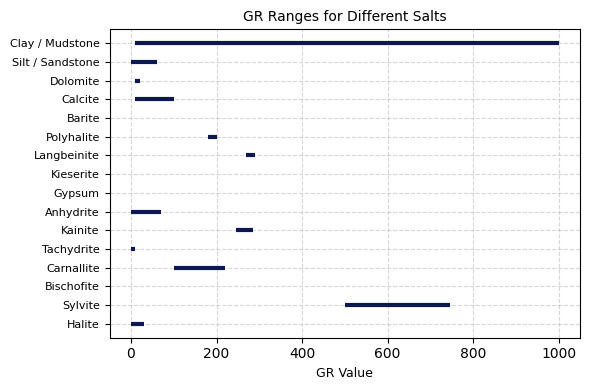

In [81]:
gr_ranges = RangePlotter("GR", GR_RANGES)
gr_ranges.plot_ranges()

In [82]:
GR_SALT_MODELS = defaultdict(Any)

for salt, _ in GR_RANGES.items():
    data = SaltOccurrences(salt, GR_RANGES)
    GR_SALT_MODELS[salt] = RangeModeler(salt, "GR", GR_RANGES, data)

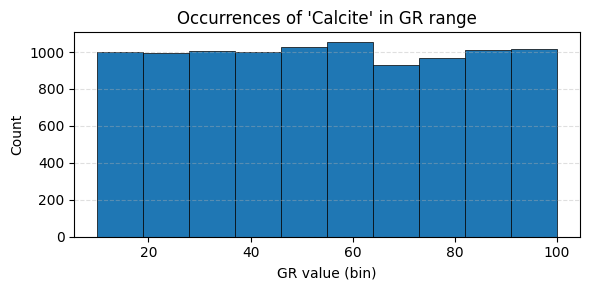

In [83]:
GR_SALT_MODELS["Calcite"].plot_salt_histogram()

#### DT

In [84]:
DT_RANGES = {
    "Halite": {"min": 65, "max": 73},
    "Sylvite": {"min": 74, "max": 74},
    "Bischofite": {"min": 100, "max": 100},
    "Carnallite": {"min": 58, "max": 78},
    "Tachydrite": {"min": 92, "max": 92},
    "Kainite": {"min": None, "max": None},
    "Anhydrite": {"min": 49, "max": 67},
    "Gypsum": {"min": 52.5, "max": 52.5},
    "Kieserite": {"min": None, "max": None},
    "Langbeinite": {"min": 52, "max": 52},
    "Polyhalite": {"min": 57.5, "max": 57.5},
    "Barite": {"min": None, "max": None},
    "Calcite": {"min": 44, "max": 90},
    "Dolomite": {"min": 58, "max": 58},
    "Silt / Sandstone": {"min": 55, "max": 88},
    "Clay / Mudstone": {"min": 48, "max": 170},
}

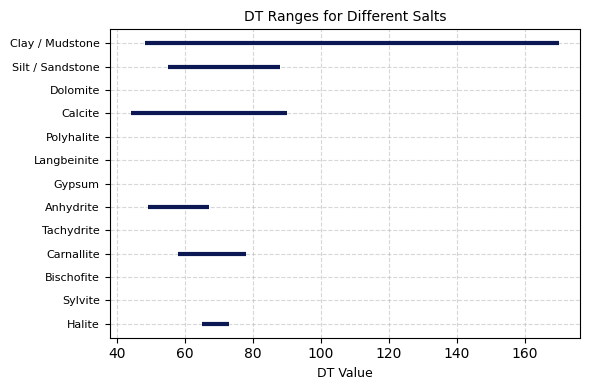

In [85]:
dt_ranges = RangePlotter("DT", DT_RANGES)
dt_ranges.plot_ranges()

In [86]:
DT_SALT_MODELS = defaultdict(Any)

for salt, _ in DT_RANGES.items():
    data = SaltOccurrences(salt, DT_RANGES)
    DT_SALT_MODELS[salt] = RangeModeler(salt, "DT", DT_RANGES, data)

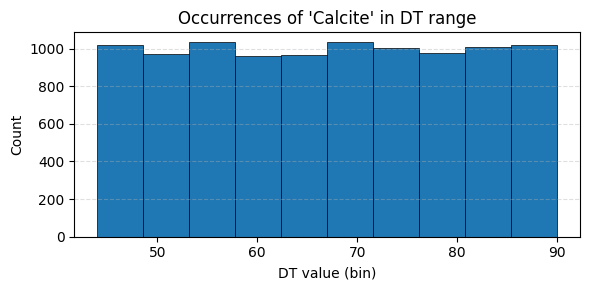

In [87]:
DT_SALT_MODELS["Calcite"].plot_salt_histogram()

#### RHOB

In [88]:
RHOB_RANGES = {
    "Halite": {"min": 1.9, "max": 2.3},
    "Sylvite": {"min": None, "max": None},
    "Bischofite": {"min": None, "max": None},
    "Carnallite": {"min": 1.57, "max": 2.2},
    "Tachydrite": {"min": 1.66, "max": 1.72},
    "Kainite": {"min": None, "max": None},
    "Anhydrite": {"min": 2.03, "max": 2.98},
    "Gypsum": {"min": None, "max": None},
    "Kieserite": {"min": None, "max": None},
    "Langbeinite": {"min": None, "max": None},
    "Polyhalite": {"min": None, "max": None},
    "Barite": {"min": None, "max": None},
    "Calcite": {"min": 2.3, "max": 2.9},
    "Dolomite": {"min": 2.683, "max": 2.88},
    "Silt / Sandstone": {"min": 2.04, "max": 2.9},
    "Clay / Mudstone": {"min": 1.6, "max": 2.95},
}


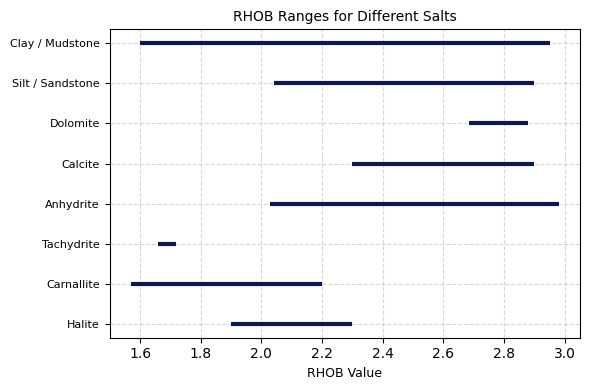

In [89]:
rhob_ranges = RangePlotter("RHOB", RHOB_RANGES)
rhob_ranges.plot_ranges()

In [90]:
RHOB_SALT_MODELS = defaultdict(RangeModeler)

for salt, _ in RHOB_RANGES.items():
    data = SaltOccurrences(salt, RHOB_RANGES)
    RHOB_SALT_MODELS[salt] = RangeModeler(salt, "RHOB", RHOB_RANGES, data)

#### NPHI

In [91]:
NPHI_RANGES = {
    "Halite": {"min": -3, "max": 0},
    "Sylvite": {"min": -3, "max": 0},
    "Bischofite": {"min": 60, "max": 100},
    "Carnallite": {"min": 60, "max": 65},
    "Tachydrite": {"min": 50, "max": 100},
    "Kainite": {"min": 45, "max": 60},
    "Anhydrite": {"min": -2, "max": 0},
    "Gypsum": {"min": 49, "max": 60},
    "Kieserite": {"min": None, "max": None},
    "Langbeinite": {"min": None, "max": None},
    "Polyhalite": {"min": None, "max": None},
    "Barite": {"min": None, "max": None},
    "Calcite": {"min": None, "max": None},
    "Dolomite": {"min": 1, "max": 4},
    "Silt / Sandstone": {"min": None, "max": None},
    "Clay / Mudstone": {"min": 25, "max": 60},
}


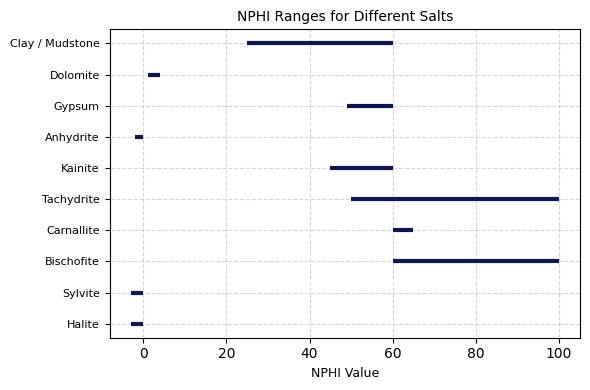

In [92]:
nphi_ranges = RangePlotter("NPHI", NPHI_RANGES)
nphi_ranges.plot_ranges()

In [93]:
NPHI_SALT_MODELS = defaultdict(RangeModeler)

for salt, _ in NPHI_RANGES.items():
    data = SaltOccurrences(salt, NPHI_RANGES)
    NPHI_SALT_MODELS[salt] = RangeModeler(salt, "NPHI", NPHI_RANGES, data)

#### PEF

In [94]:
PEF_RANGES = {
    "Halite": {"min": 4.65, "max": 4.72},
    "Sylvite": {"min": 8.51, "max": 8.76},
    "Bischofite": {"min": None, "max": None},
    "Carnallite": {"min": 4.09, "max": 4.29},
    "Tachydrite": {"min": 3.82, "max": 3.84},
    "Kainite": {"min": None, "max": None},
    "Anhydrite": {"min": 5.05, "max": 5.1},
    "Gypsum": {"min": 3.99, "max": 4},
    "Kieserite": {"min": 1.8, "max": 1.83},
    "Langbeinite": {"min": None, "max": None},
    "Polyhalite": {"min": None, "max": None},
    "Barite": {"min": None, "max": None},
    "Calcite": {"min": None, "max": None},
    "Dolomite": {"min": 3.09, "max": 3.14},
    "Silt / Sandstone": {"min": 1.7, "max": 2.7},
    "Clay / Mudstone": {"min": 3, "max": 5},
}


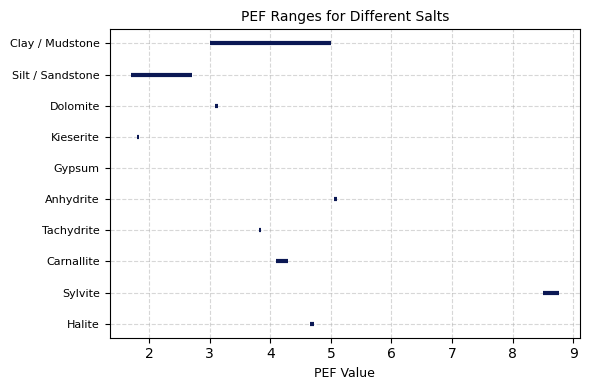

In [95]:
pef_ranges = RangePlotter("PEF", PEF_RANGES)
pef_ranges.plot_ranges()

In [96]:
PEF_SALT_MODELS = defaultdict(RangeModeler)

for salt, _ in PEF_RANGES.items():
    data = SaltOccurrences(salt, PEF_RANGES)
    PEF_SALT_MODELS[salt] = RangeModeler(salt, "PEF", PEF_RANGES, data)

### Model

Statistical model

In [132]:
salts = ['Halite', 'Sylvite', 'Bischofite', 'Carnallite', 'Tachydrite', 'Kainite', 'Anhydrite', 'Gypsum', 'Kieserite', 'Langbeinite', 'Polyhalite', 'Barite', 'Calcite', 'Dolomite', 'Silt / Sandstone', 'Clay / Mudstone']

measurements = ["GR", "DT", "RHOB", "NPHI", "PEF"]

model_sets = {
    "GR": GR_SALT_MODELS,
    "DT": DT_SALT_MODELS,
    "RHOB": RHOB_SALT_MODELS,
    "NPHI": NPHI_SALT_MODELS,
    "PEF": PEF_SALT_MODELS,
}

In [123]:
class SaltComposition:
    def __init__(self, depth: float, model: dict):
        self.depth = depth
        self.model = model

    def plot_pie_chart(self):
        labels = list(self.model.keys())
        sizes = list(self.model.values())

        # Make a pie chart
        plt.figure(figsize=(6,6))
        plt.pie(
            sizes, 
            labels=labels, 
            autopct="%1.1f%%", 
            startangle=140, 
            pctdistance=0.85
        )
        plt.title(f"Salt Probability Distribution at Depth {self.depth:.2f} m")
        plt.show()

#### Betas

Beta, 𝛽, values capture how reliable each measurement is at identifying a salt.

- 𝛽 = 1 → normal
- 𝛽 > 1 → reliable, weight these measurements higher
- 𝛽 < 1 → unreliable, discount these measurements

For example,

If we know Gamma Ray (GR) values in the 'Halite' salt range are very string signals of the existence of 'Halite', then adjust the 𝛽 value to '2.0'.


> These values can and should be tweaked with emprical evidence!


In [135]:
# Set initial betas to 1.0
betas = {salt: {m: 1.0 for m in measurements} for salt in salts}

# Example usage
# - update specific measurement weights for a given salt

# betas["Halite"].update({"GR": 2.0})
# betas["Sylvite"].update({"GR": 1.5, "RHOB": 1.2, "NPHI": 0.3, "PEF": 1.5})


#### Priors

Prior, `𝜋_salt`, values capture your geological expectation of the presence of each salt

Define `𝜋_salt` such that `0 <= 𝜋_salt <= 1` such that the `sum(𝜋_salt) = 1`.

For example,

If we know 'Halite' is dominant then we can favour by increasing 𝜋_halite
If we know 'Dolomite' is not possible to find in this specific geography we can set 𝜋_dolomite to zero.

In [136]:
# Set initial priors to uniform distribution
priors = {s: 1/len(salts) for s in salts}

# Example usage
# - update specific priors for a given salt

# priors["Halite"] = 0.5
# priors["Dolomite"] = 0.0

In [137]:
def posterior_probs_with_decay(weightings_matrix, betas, priors, eps=1e-6):
    scores = {}

    for salt, log_weights in weightings_matrix.items():
        score = priors.get(salt, 1.0)
        for log, w in log_weights.items():
            beta = betas.get(salt, {}).get(log, 1.0)
            # Avoid zero**beta
            score *= max(w, eps) ** beta
        scores[salt] = score

    total = sum(scores.values())
    if total > 0:
        probs = {s: scores[s]/total for s in scores}
    else:
        probs = {s: 0.0 for s in scores}

    return OrderedDict(sorted(probs.items(), key=lambda x: x[1], reverse=True))


In [141]:
def posterior_probs(weights, betas, priors, eps=1e-6):
    
    measurements = next(iter(weights.values())).keys()
    if betas is None:
        betas = {m: 1.0 for m in measurements}
    if priors is None:
        S = len(weights)
        priors = {s: 1.0/S for s in weights}

    odds = {}
    for s, wm in weights.items():
        prior = priors[s]
        s_odds = prior / max(1 - prior, eps)
        for m, w in wm.items():
            # skip missing w=None
            if w is None: 
                continue
            lr = ((w + eps) / (1 - w + eps)) ** betas[m]
            s_odds *= lr
        odds[s] = s_odds

    total = sum(odds.values())
    probs = {s: (odds[s] / total) if total > 0 else 0.0 for s in odds}

    probs_sorted = OrderedDict(sorted(probs.items(), key=lambda x: x[1], reverse=True))
    return probs_sorted


### Estimate Salt Composition

In [138]:
# Decay factor: how much we trust previous depth
alpha = 0.0  # 0 = ignore previous, 1 = fully trust previous

# Store results
results = []

for _, row in RUDSTON_2_DATA.iterrows():
    depth = row["DEPTH"]
    
    # Build weightings matrix for this depth
    weightings_matrix = {
        salt: {m: model_sets[m][salt].calculate_weighting(row[m]) for m in measurements}
        for salt in salts
    }
    
    # Compute posterior probabilities
    posteriors = posterior_probs_with_decay(weightings_matrix, betas, priors)
    
    # Save results
    results.append({"Depth": depth, "Model": posteriors})
    
    # Update priors for next depth using decay factor
    priors = {s: alpha*posteriors[s] + (1-alpha)*(1/len(salts)) for s in salts}

In [139]:
for r in results:
    print(r)

{'Depth': np.float64(7644.0), 'Model': OrderedDict({'Clay / Mudstone': 0.9999905291491157, 'Calcite': 9.470556640698452e-06, 'Anhydrite': 1.0206805826495999e-10, 'Dolomite': 9.840523705761954e-11, 'Silt / Sandstone': 9.376926992684235e-11, 'Halite': 9.694619679584209e-16, 'Sylvite': 9.69461967958421e-21, 'Bischofite': 9.69461967958421e-21, 'Carnallite': 9.69461967958421e-21, 'Tachydrite': 9.69461967958421e-21, 'Kainite': 9.69461967958421e-21, 'Gypsum': 9.69461967958421e-21, 'Kieserite': 9.69461967958421e-21, 'Langbeinite': 9.69461967958421e-21, 'Polyhalite': 9.69461967958421e-21, 'Barite': 9.69461967958421e-21})}
{'Depth': np.float64(7643.5), 'Model': OrderedDict({'Clay / Mudstone': 0.9999903013921692, 'Calcite': 9.69830328891203e-06, 'Silt / Sandstone': 1.0526298887777332e-10, 'Anhydrite': 1.0452257694231183e-10, 'Dolomite': 9.475545344612395e-11, 'Halite': 9.92775456505044e-16, 'Sylvite': 9.92775456505044e-21, 'Bischofite': 9.92775456505044e-21, 'Carnallite': 9.92775456505044e-21, 'T

In [142]:
results = []

for _, row in RUDSTON_2_DATA.iterrows():
    depth = row["DEPTH"]
    
    # Build weightings per salt
    weightings_matrix = {
        salt: {
            m: model_sets[m][salt].calculate_weighting(row[m]) 
            for m in measurements
        }
        for salt in salts
    }

    model = posterior_probs(weightings_matrix, betas, priors)
    results.append({"Depth": depth, "Model": model})

KeyError: 'GR'

In [121]:
results_df = pd.DataFrame(results)

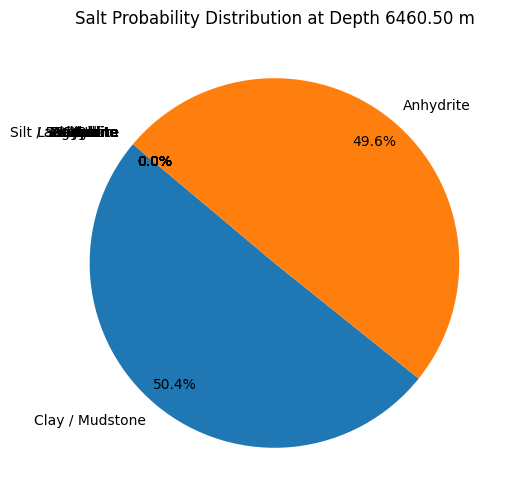

In [129]:
row = results_df[results_df["Depth"] == 6460.5].iloc[0]
depth = row["Depth"]
model = row["Model"]

pie = SaltComposition(depth, model)
pie.plot_pie_chart()